Notebook de ejecución de los ejemplos de uso de las redes neuronales con los conjuntos de datos seleccionados

Librerías externas utilizadas:
- numpy 
- pandas <- principalmente para carga y manejo de datasets
- matplotlib <- para visualización de datos´
- sklearn <- para la división de los datos en entrenamiento y test y codificación de variables
- cv2 <- para el procesamiento de imágenes, necesario para los datasets de imágenes
- os <- para el manejo de directorios y archivos donde se encuentran las imágenes de los datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from network import Network
from fc_layer import FCLayer
from activation_layer import ActivationLayer
from conv_layer import ConvLayer
from flatten_layer import FlattenLayer
from activations import tanh, tanh_prime, ReLU_deriv, ReLU, sigmoid, sigmoid_deriv
from losses import mse, mse_prime, cross_entropy_loss, cross_entropy_loss_derivative, binary_cross_entropy, binary_cross_entropy_derivative

import cv2
import os

Funciones propias utilizadas para el manejo de los datos de entrada de nuestras redes neuronales:

In [2]:
def custom_to_categorical(labels, num_classes):
    num_samples = len(labels)
    categorical_labels = np.zeros((num_samples, num_classes))
    
    for i in range(num_samples):
        label = labels[i]
        categorical_labels[i, label] = 1
    
    return categorical_labels

def load_images(folder_path, label_dict, size):
    images = []
    labels = []

    for label, value in label_dict.items():
        path = os.path.join(folder_path, label)
        for filename in os.listdir(path):
            img = cv2.imread(os.path.join(path, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (size, size))
                images.append(img)
                labels.append(value)

    return np.array(images), np.array(labels)

def load_limited_images(folder_path, label_dict,size,limit=1000):
    images = []
    labels = []
    count = {0: 0, 1: 0}
    for label, value in label_dict.items():
        path = os.path.join(folder_path, label)
        for filename in os.listdir(path):
            if count[value] >= limit:
                continue
            img = cv2.imread(os.path.join(path, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (size, size))
                images.append(img)
                labels.append(value)
                count[value] += 1

    return np.array(images), np.array(labels)

Ejemplo 1: Ejecucución de una red neuronal con el dataset: digit-recognizer

Pasos:
- Cargamos el dataset y separamos los datos en X e Y
- Normalizamos los datos de X para que se encuentren entre 0 y 1
- Separamos los datos en entrenamiento y test
- Cambiamos la dimension de los datos de X para que tengan la dimensión: (33600, 1, 784) para que se puedan introducir en la red neuronal, donde el primer valor es el numero de datos, el segundo el batch_size(que debe ser 1) y el tercero el numero de características.
- Cambiamos la codificación de los datos de Y para que se encuentren en formato one-hot.
- Creamos la red neuronal, especificando el numero de capas, el numero de neuronas por capa, la función de activación y la función de perdida.
- Entrenamos la red neuronal con los datos de entrenamiento y comprobamos la precisión con los datos de test
- Graficamos la precisión y la pérdida durante el entrenamiento

(33600, 1, 784)
epoch 1/35   error=0.064740
epoch 2/35   error=0.045576
epoch 3/35   error=0.041819
epoch 4/35   error=0.039658
epoch 5/35   error=0.038143
epoch 6/35   error=0.036974
epoch 7/35   error=0.036020
epoch 8/35   error=0.035218
epoch 9/35   error=0.034528
epoch 10/35   error=0.033927
epoch 11/35   error=0.033395
epoch 12/35   error=0.032922
epoch 13/35   error=0.032496
epoch 14/35   error=0.032110
epoch 15/35   error=0.031759
epoch 16/35   error=0.031437
epoch 17/35   error=0.031142
epoch 18/35   error=0.030869
epoch 19/35   error=0.030616
epoch 20/35   error=0.030382
epoch 21/35   error=0.030163
epoch 22/35   error=0.029959
epoch 23/35   error=0.029768
epoch 24/35   error=0.029589
epoch 25/35   error=0.029420
epoch 26/35   error=0.029259
epoch 27/35   error=0.029108
epoch 28/35   error=0.028963
epoch 29/35   error=0.028825
epoch 30/35   error=0.028693
epoch 31/35   error=0.028566
epoch 32/35   error=0.028444
epoch 33/35   error=0.028326
epoch 34/35   error=0.028211
epoch 3

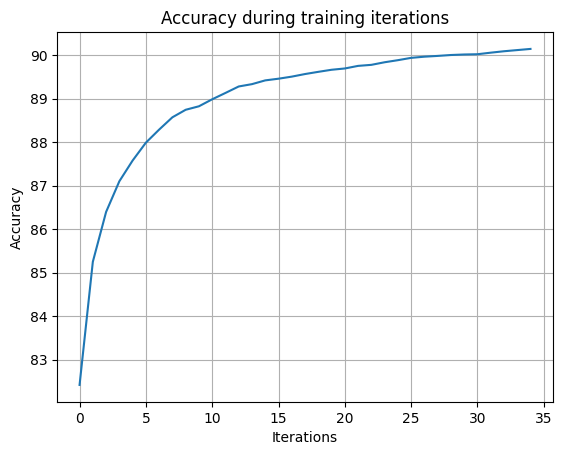

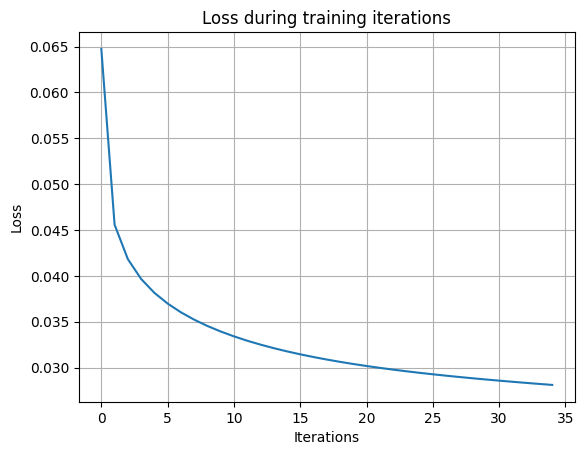

In [25]:
data = pd.read_csv('digit-recognizer/train/train.csv')

X = data.drop(columns=['label']).values
Y = data['label'].values

X_normalized = X / 255.0
X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y, test_size=0.2, random_state=42)

X_train_reshaped = X_train.reshape(-1, 1, X_train.shape[1]).astype('float32')
X_test_reshaped = X_test.reshape(-1, 1, X_test.shape[1]).astype('float32')

num_classes = np.max(Y_train) + 1

Y_train_categorical = custom_to_categorical(Y_train, num_classes)
Y_test_categorical = custom_to_categorical(Y_test, num_classes)

net = Network()
net.add(FCLayer(28*28, 100))              
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(100, 50))                
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(50, 10))                 
net.add(ActivationLayer(tanh, tanh_prime))

net.use(mse, mse_prime)
net.fit(X_train_reshaped, Y_train_categorical, epochs=35, learning_rate=0.001)

out = net.predict(X_test_reshaped)

accuracy = net.calculate_accuracy(out, Y_test_categorical)
print('Accuracy: {:.2%}'.format(accuracy/100))
net.graph_accuracy()
net.graph_loss()

Ejemplo 2: Ejecucución de una red neuronal con el dataset: PetImages: Cats vs Dogs

Pasos:
- Cargamos el dataset, obteniendo las imágenes y las etiquetas
- Normalizamos las imágenes entre 0 y 1
- Separar las imágenes en entrenamiento y test
- Aseguramos que las etiquetas se encuentran en formato categórico con nuestro custom_to_categorical()
- Creamos la red neuronal, donde nuestras capas convolutivas tienen un padding y un stride de 1, por lo que la dimensión de las imágenes se ven reducidas en 2 en cada capa convolutiva. 
- Entrenamos la red neuronal con los datos de entrenamiento y comprobamos la precisión con los datos de test
- Graficamos la precisión y la pérdida durante el entrenamiento

epoch 1/10   error=0.746663
epoch 2/10   error=0.698798
epoch 3/10   error=0.697319
epoch 4/10   error=0.697289
epoch 5/10   error=0.697276
epoch 6/10   error=0.697270
epoch 7/10   error=0.697267
epoch 8/10   error=0.697265
epoch 9/10   error=0.697264
epoch 10/10   error=0.697264


predicted values : 
accuracy : 51.66666666666667


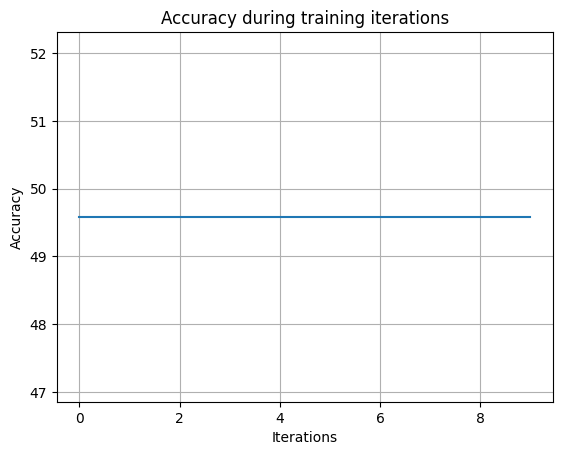

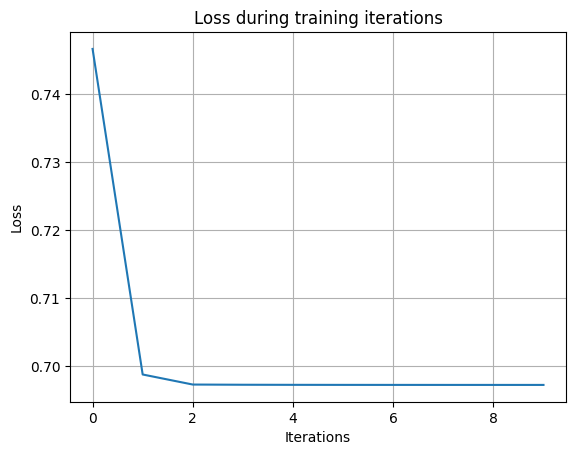

In [27]:
data_folder = r'archive (3)/PetImages'

label_dict = {'Cat': 0, 'Dog': 1}
size = 64
images, labels = load_limited_images(data_folder, label_dict,size,limit=200)
images = images / 255.0

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

train_labels = custom_to_categorical(train_labels, 2)
test_labels = custom_to_categorical(test_labels, 2)

net = Network()
net.add(ConvLayer((64, 64, 3), (3, 3), 3)) 
net.add(ActivationLayer(sigmoid, sigmoid_deriv))
net.add(ConvLayer((62, 62, 3), (3, 3), 3))
net.add(ActivationLayer(sigmoid, sigmoid_deriv))
net.add(ConvLayer((60, 60, 3), (3, 3), 3))
net.add(ActivationLayer(sigmoid, sigmoid_deriv))
net.add(FlattenLayer())                   
net.add(FCLayer(58*58*3, 400))            
net.add(ActivationLayer(sigmoid, sigmoid_deriv))
net.add(FCLayer(400, 2))              
net.add(ActivationLayer(sigmoid, sigmoid_deriv))

net.use(binary_cross_entropy, binary_cross_entropy_derivative)
net.fit(train_images, train_labels, epochs=10, learning_rate=0.05)

out = net.predict(test_images)
print("\n")
print("predicted values : ")
accuracy = net.calculate_accuracy(out, test_labels)
print('Accuracy: {:.2%}'.format(accuracy/100))
net.graph_accuracy()
net.graph_loss()

Ejemplo 3: Ejecucución de una red neuronal con el dataset: hotdog: hotdog or nothotdog

Pasos:
- Cargamos el dataset, obteniendo las imágenes y las etiquetas
- Normalizamos las imágenes entre 0 y 1
- Separar las imágenes en entrenamiento y test
- Aseguramos que las etiquetas se encuentran en formato categórico con nuestro custom_to_categorical()
- Creamos la red neuronal.
- Entrenamos la red neuronal con los datos de entrenamiento y comprobamos la precisión con los datos de test
- Graficamos la precisión y la pérdida durante el entrenamiento

epoch 1/10   error=0.740282
epoch 2/10   error=0.678599
epoch 3/10   error=0.649136
epoch 4/10   error=0.623097
epoch 5/10   error=0.596381
epoch 6/10   error=0.568725
epoch 7/10   error=0.535227
epoch 8/10   error=0.492203
epoch 9/10   error=0.450511
epoch 10/10   error=0.397663


Accuracy: 61.25%


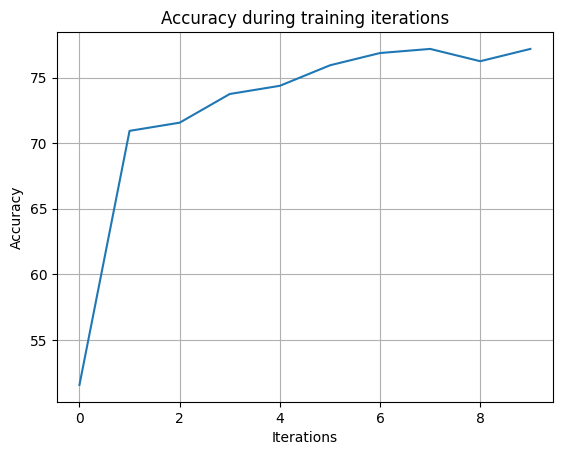

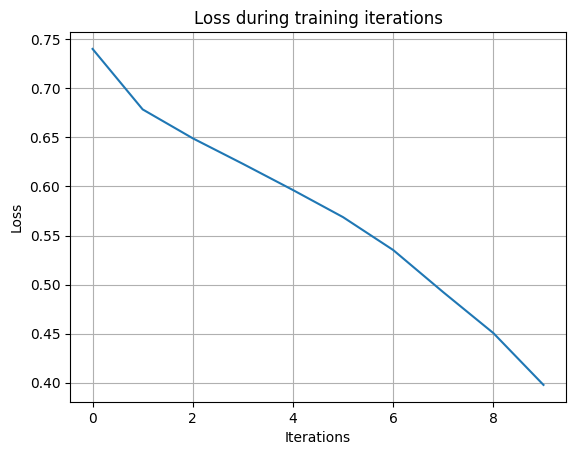

In [29]:
data_folder = r'hotdog/hotdog'

label_dict = {'hotdog': 0, 'nothotdog': 1}
size = 48
images, labels = load_limited_images(data_folder,label_dict,size, limit=200)
images = images / 255.0

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

train_labels = custom_to_categorical(train_labels, 2)
test_labels = custom_to_categorical(test_labels, 2)

net = Network()
net.add(ConvLayer((48, 48, 3), (3, 3), 3)) 
net.add(ActivationLayer(sigmoid, sigmoid_deriv))
net.add(ConvLayer((46, 46, 3), (3, 3), 3)) 
net.add(FlattenLayer())                   
net.add(FCLayer(44*44*3, 250))            
net.add(ActivationLayer(sigmoid, sigmoid_deriv))
net.add(FCLayer(250, 2))              
net.add(ActivationLayer(sigmoid, sigmoid_deriv))

net.use(binary_cross_entropy, binary_cross_entropy_derivative)
net.fit(train_images, train_labels, epochs=10, learning_rate=0.01)

out = net.predict(test_images)
print("\n")
accuracy = net.calculate_accuracy(out, test_labels)
print('Accuracy: {:.2%}'.format(accuracy/100))
net.graph_accuracy()
net.graph_loss()

Ejemplo 4: Ejecucución de una red neuronal con el dataset: healthcare-dataset-stroke-data

Pasos:
- Cargamos el dataset, haciendo un preprocesamiento de los datos para eliminar los datos nulos y normalizando los datos usando un MinMaxScaler y un LabelEncoder para obtener todas las variables en un rango entre 0 y 1. Además, las categorías de las variables categóricas se codifican en formato one-hot.
- Separamos los datos en entrenamiento y test
- Ajustamos las dimensiones de los datos para que se puedan introducir en la red neuronal.
- Creamos la red neuronal.
- Entrenamos la red neuronal con los datos de entrenamiento y comprobamos la precisión con los datos de test
- Graficamos la precisión y la pérdida durante el entrenamiento

epoch 1/35   error=nan
epoch 2/35   error=nan
epoch 3/35   error=nan
epoch 4/35   error=nan
epoch 5/35   error=nan
epoch 6/35   error=nan
epoch 7/35   error=nan
epoch 8/35   error=nan
epoch 9/35   error=nan
epoch 10/35   error=nan
epoch 11/35   error=nan
epoch 12/35   error=nan
epoch 13/35   error=nan
epoch 14/35   error=nan
epoch 15/35   error=nan
epoch 16/35   error=nan
epoch 17/35   error=nan
epoch 18/35   error=nan
epoch 19/35   error=nan
epoch 20/35   error=nan
epoch 21/35   error=nan
epoch 22/35   error=nan
epoch 23/35   error=nan
epoch 24/35   error=nan
epoch 25/35   error=nan
epoch 26/35   error=nan
epoch 27/35   error=nan
epoch 28/35   error=nan
epoch 29/35   error=nan
epoch 30/35   error=nan
epoch 31/35   error=nan
epoch 32/35   error=nan
epoch 33/35   error=nan
epoch 34/35   error=nan
epoch 35/35   error=nan
Accuracy: 100.00%


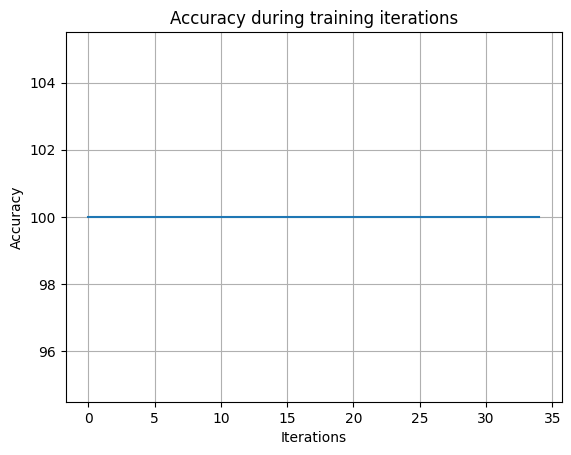

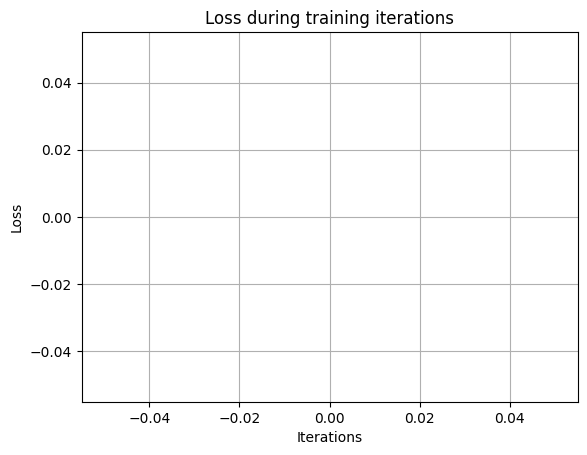

In [3]:
data = pd.read_csv("archive (1) (1)/archive (1)/healthcare-dataset-stroke-data.csv")
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in categorical_columns:
    encoded_columns = pd.get_dummies(data[col], prefix=col, drop_first=False)
    data = pd.concat([data, encoded_columns], axis=1)
    data.drop(col, axis=1, inplace=True)

X_data = data.drop(columns=['stroke', 'id'])
Y = data['stroke']
rows_with_nan = data[data.isnull().any(axis=1)]

data_without_nan = data.dropna()
numeric_columns = X_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = MinMaxScaler()
X_data[numeric_columns] = scaler.fit_transform(X_data[numeric_columns])

label_encoder = LabelEncoder()
for column in X_data.select_dtypes(exclude=['float64', 'int64']):
    X_data[column] = label_encoder.fit_transform(X_data[column])

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y, test_size=0.2, random_state=42)

X_train_reshaped = X_train.values.reshape(-1, 1, X_train.shape[1])
X_test_reshaped = X_test.values.reshape(-1, 1, X_test.shape[1])
Y_train = Y_train.values.reshape(-1, 1)
Y_test = Y_test.values.reshape(-1, 1)
net = Network()
net.add(FCLayer(21, 1))               
net.add(ActivationLayer(ReLU, ReLU_deriv)) 

net.use(binary_cross_entropy, binary_cross_entropy_derivative)
net.fit(X_train_reshaped, Y_train, epochs=35, learning_rate=0.01)

out = net.predict(X_test_reshaped)
accuracy = net.calculate_accuracy(out, Y_test)
print('Accuracy: {:.2%}'.format(accuracy/100))
net.graph_accuracy()
net.graph_loss()